# Solution to Shayan Monadjemi's Assessment 1

## Part A

### Plotting code:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

### GP implementation:

In [3]:
def sqdist(X):
    G = (X**2).reshape(-1,1)
    return G + G.T - 2 * np.dot(X,X.T)

def SEkernel(X):
    sqd = sqdist(X)
    return np.exp(-.5 * sqd)
    
X_f = np.arange(0,30,.25).reshape(-1,1) # define domain for f as described in problem and reshape to a column vector
u = np.zeros(X_f.shape) # define mean function as zero vector over domain
K_f = SEkernel(X_f) # generate covariance matrix

### Plotted prior w/ mean:

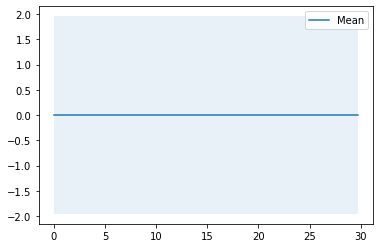

In [24]:
plot_gp(u, K_f, X_f) # plot prior and mean

## Part B:

In [4]:
samples = np.random.multivariate_normal(u.ravel(), K_f, 3) # sample prior

### Plotted prior w/ mean & samples:

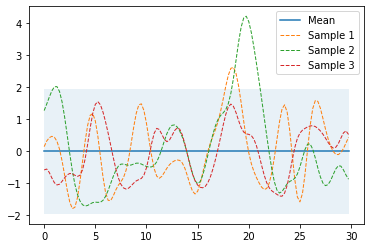

In [26]:
plot_gp(u, K_f, X_f, samples=samples)

## Part C:

In [5]:
def sqdist_joint(X1, X2):
    G1 = (X1**2).reshape(-1,1)
    G2 = (X2**2).reshape(-1,1)
    return G1 + G2.T - 2 * np.dot(X1,X2.T)

def SEkernel_joint(X1, X2):
    sqd = sqdist_joint(X1, X2)
    return np.exp(-.5 * sqd)


X_g = np.arange(0,30,.25).reshape(-1,1) # define domain for g
corr = .85 # define correlation between functions as described in problem
K_g = SEkernel(X_g) # define cov for g
K_fg_marg = SEkernel_joint(X_f, X_g) # define marginal covariance of f and g 
K_fg = corr * K_fg_marg # Joing cov = correlation * marginal cov, as described in book
fSamples = np.random.multivariate_normal(u.ravel(), K_f, 1) # sample prior for f
gSamples = np.random.multivariate_normal(u.ravel(), K_g, 1) # sample prior for g
jointSamples = np.concatenate([fSamples, gSamples],axis=0)

### Plotted joint prior with mean and joint sample:

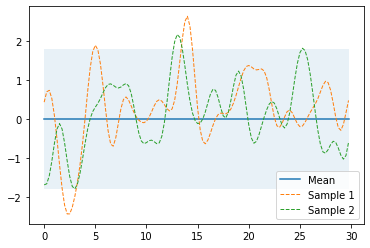

In [65]:
plot_gp(u, K_fg, X_f, samples=jointSamples)

## Part D:

### Prediction code:

In [6]:
from numpy.linalg import inv
def predict(X, X_train, Y_train, kernFunc):
    C = kernFunc(X_train, X_train)
    kappa = kernFunc(X_train, X)
    K = kernFunc(X,X)+1e-8 * np.eye(len(X))
    
    u = kappa.T.dot(inv(C)).dot(Y_train)
    cov = K - kappa.T.dot(inv(C)).dot(kappa)
    return u, cov

#     if not np.isfinite(C).all():
#         C = np.nan_to_num(C)
#     cho = cho_factor(C,lower=True)
#     L = cho[0]
#     lower = cho[1]
#     upper = not lower
#     v = cho_solve((L.T, upper), kappa)
#     b = cho_solve(cho, Y_train)
#     alpha = cho_solve((L.T, upper), b)
    
# #     print(f'{K.shape} {kappa.shape}')
#     u = kappa.T.dot(alpha)
#     cov = K - np.dot(v.T, v)
#     ml = -.5 * (Y_train.T.dot(alpha) + 2 * np.sum(np.log(np.diag(L))) + len(X_train) * np.log(2 * np.pi))
#     return u, cov, ml
#     except:
#     print(f'{kappa.shape} {Y_train.shape} {C.shape}')

### Scenario 1:

In [7]:
x_train_inds = np.random.choice(np.arange(30), 2, replace=False)
y_train = np.zeros(2).reshape(-1,1)
y_train[np.arange(2)] = fSamples[0].reshape(-1,1)[x_train_inds]
x_train = x_train_inds.reshape(-1,1)

In [19]:
print(f'{X_f.shape} {x_train.shape}')

(120, 1) (2, 1)


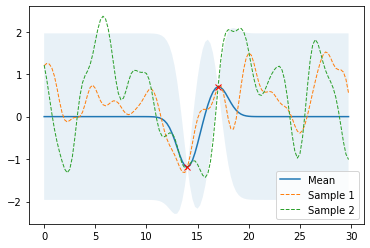

In [191]:
u_posterior, K_posterior = predict(X_f, x_train, y_train, SEkernel_joint)
post_samples = np.random.multivariate_normal(u_posterior.ravel(), K_posterior, 2)
plot_gp(u_posterior, K_posterior, X_f, X_train=x_train, Y_train=y_train, samples=post_samples)

### Scenario 2:

In [193]:
x_train_inds = np.random.choice(np.arange(30), 20, replace=False)
y_train = np.zeros(20).reshape(-1,1)
y_train[np.arange(20)] = gSamples[0].reshape(-1,1)[x_train_inds]
x_train = x_train_inds.reshape(-1,1)

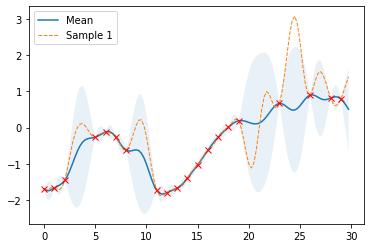

In [194]:
u_posterior, K_posterior = predict(X_g, x_train, y_train, SEkernel_joint)
post_samples = np.random.multivariate_normal(u_posterior.ravel(), K_posterior, 1)
plot_gp(u_posterior, K_posterior, X_g, X_train=x_train, Y_train=y_train, samples=post_samples)

### Scenario 3:

Ran out of time

# Reflection

## Scope

I felt the scope of this assignment was very good for the amount of content that it was able to ask questions on. Going into joint GPs was appreciated, as I didn't understand how to model them as well.

## Difficulty

This would have been much more difficult than intended if I did not already have starter code for plotting GPs from when I wrote my assignment. It would have been helpful to provide starter code or at least suggest a library.

## Usefulness

Very useful in understanding joint GPs and all of the content in chapter 2 sans noisy observation

## Comments

Not sure if I was doing the modeling and sampling of joint GPs correctly, but it seemed like my outputs were correct. Some more guidance on part D would have been nice, as I had to play around a lot to figure out exactly what I was supposed to be doing, causing me to run out of time.